In [1820]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Assuming you might need it

# Specific models and tools
from xgboost import XGBClassifier
import xgboost as xgb

# Encoding and feature selection
from category_encoders import TargetEncoder  # Fixed the import based on usage
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [1821]:
competitions = [

    # Code, Seasons
    ['E0', [2324, 2223, 2122, 2021, 1920]],
    ['D1', [2324, 2223, 2122, 2021, 1920]],
    ['I1', [2324, 2223, 2122, 2021, 1920]],



]

In [1822]:
matches_files = []

In [1823]:
for comp in competitions:

    for season in comp[1]:

        matches_files.append(f"data/matches/{comp[0]}_{season}.csv")

In [1824]:
# Load and concatenate matches data into a single DataFrame
df = pd.DataFrame()

for file in matches_files:

    try:
        df_temp = pd.read_csv(file)
        df = pd.concat([df, df_temp], ignore_index=True)
    except:
        # print an error message
        print(f'Error: {file} not found')

# print the amount of data loaded
print(f"Data loaded: {df.shape[0]} matches")

Data loaded: 5080 matches


In [1825]:
# Convert all columns to lowercase
df.columns = df.columns.str.lower()

In [1826]:
# Rename 'HomeTeam' to 'Team' in df
df.rename(columns={'hometeam': 'team'}, inplace=True)
df.rename(columns={'awayteam': 'opponent'}, inplace=True)

In [1827]:
df.head()

,div,date,time,team,opponent,fthg,ftag,ftr,hthg,htag,...,bbmx>2.5,bbav>2.5,bbmx<2.5,bbav<2.5,bbah,bbahh,bbmxahh,bbavahh,bbmxaha,bbavaha
0,E0,11/08/2023,20:00,Burnley,Man City,0,3,A,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2,1,H,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1,1,D,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4,1,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0,1,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1828]:
# Convert 'Div' to a categorical type, a numeric representation of the division
df['div'] = df['div'].astype('category').cat.codes

In [1829]:
# Create a unique list of HomeTeam and AwayTeam names combined, and add an index to each team
teams = pd.concat([df['team'], df['opponent']]).unique()

# Sort the teams alphabetically
teams.sort()

# Convert to an array of dictionaries
teams = [{'team': team, 'index': index} for index, team in enumerate(teams)]

In [1830]:
# Create a unique list of Referees, and add an index to each Referee
referees = pd.concat([df['referee']]).unique()

# Remove any missing values
referees = referees[~pd.isnull(referees)]

# Sort the teams alphabetically
referees.sort()

# Convert to an array of dictionaries
referees = [{'referee': referee, 'index': index} for index, referee in enumerate(referees)]

In [1831]:
# Map the referee names to the index
df['referee_id'] = df['referee'].map({referee['referee']: referee['index'] for referee in referees})

In [1832]:
df['ftr_code'] = df['ftr']

# Map the FTR column to a binary outcome
#df['FTR'] = df['FTR'].map({'H': 1, 'D': 0, 'A': 2}).astype(int)
#df['HTR'] = df['HTR'].map({'H': 1, 'D': 0, 'A': 2}).astype(int)

In [1833]:
# Map the team names to the index values in the 'teams' list
df['team_id'] = df['team'].map({team['team']: team['index'] for team in teams})
df['opp_id'] = df['opponent'].map({team['team']: team['index'] for team in teams})

In [1834]:
# Date is in DD/MM/YYYY format, convert it to a datetime object
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Declare Date_temp as a temporary column, an 8 digit integer representation of the date
df['date_temp'] = df['date'].dt.year * 10000 + df['date'].dt.month * 100 + df['date'].dt.day

# Connvert 'Time', which is now in HH:MM format to a 4 digit integer
# Assuming a default time of 00:00 for missing values
df['time'] = df['time'].fillna('00:00').str.replace(':', '').astype(int)

In [1835]:
df.columns = [re.sub(r'[<]', '_st_', str(col)) for col in df.columns]
df.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in df.columns]

In [1836]:
# Apply the modified function to create new columns

#df['opp_hist_vs'] = df.apply(lambda x: history_vs_opponent_weighted(df, x, 'AwayTeam_ID'), axis=1)

In [1837]:
df = df[['div', 'date', 'date_temp', 'time', 'team_id', 'opp_id', 
         
         #'referee_id',          
         
#'fthg',
#'ftag',
'ftr',
#'hthg',
#'htag',
#'htr',
#'hs',
#'as',
#'hst',
#'ast',
#'hf',
#'af',
#'hc',
#'ac',
#'hy',
#'ay',
#'hr',
#'ar',

'avgh',
'avgd',
'avga',  

#'team_hist_vs',
#'opp_hist_vs'
         
         
         
         
         ]]

In [1838]:
df['venue'] = 1

In [1839]:
# Drop multiple columns
df = df.drop(['date'], axis=1)

In [1840]:
df.columns

Index(['div', 'date_temp', 'time', 'team_id', 'opp_id', 'ftr', 'avgh', 'avgd',
       'avga', 'venue'],
      dtype='object')

In [1841]:
import pandas as pd

# assuming df is your original dataframe
# duplicate the dataframe
df_duplicate = df.copy()

# switch the values of hometeam_id and awayteam_id
df_duplicate[['team_id', 'opp_id']] = df_duplicate[['opp_id', 'team_id']].values

# switch the values of b365h and b365a
df_duplicate[['avgh', 'avga']] = df_duplicate[['avga', 'avgh']].values

# switch the values of probs_win and probs_not_win
#df_duplicate[['probs_win', 'probs_not_win']] = df_duplicate[['probs_not_win', 'probs_win']].values

df_duplicate['venue'] = 0

In [1842]:
# Concatenate the original dataframe with the modified duplicate
df = pd.concat([df, df_duplicate], ignore_index=True)

In [1843]:
df['ftr'] = df['ftr'].map({'H': 1, 'D': 0, 'A': 0}).astype(int)

In [1844]:
def history_vs_opponent_weighted(df, row, team_column):
    """
    Calculate the weighted average of points scored by a team against a specific opponent
    in their 5 most recent matches before the date of the current match. Points are awarded 
    based on the match result: 3 points for a win, and 1 point for a draw. The most recent match
    has more weight than the older matches.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing match data.
    - row (pd.Series): The current row being evaluated, used to identify the team and opponent.
    - team_column (str): The column name in df that identifies the team.
    
    Returns:
    float: The normalized weighted score for the team against the specified opponent.
    """
    
    opponent_column = 'opp_id'

    # Filter DataFrame for relevant matches before the current date_temp
    df_temp = df[
        (df['date_temp'] < row['date_temp']) & 
        ((df['team_id'] == row[team_column]) | (df['opp_id'] == row[team_column]))
    ].sort_values(by='date_temp', ascending=False).head(5)

    # Initialize the weighted score and the total possible weight
    weighted_score = 0
    total_weight = sum(range(1, len(df_temp) + 1))  # The sum of weights from 1 to n (number of matches)

    # Iterate through the matches with a weight from 5 (most recent) to 1 (least recent)
    for weight, (index, match) in zip(range(len(df_temp), 0, -1), df_temp.iterrows()):
        # Determine points based on match result
        points = 0
        if match[team_column] == row['team_id']:
            if match['ftr'] == 'H':
                points = 3
            elif match['ftr'] == 'D':
                points = 1
        else:
            if match['ftr'] == 'A':
                points = 3
            elif match['ftr'] == 'D':
                points = 1

        # Multiply the points by the match's weight
        weighted_score += points * weight

    # Normalize the weighted score by the sum of the weights
    normalized_weighted_score = weighted_score / total_weight if total_weight > 0 else 0
    
    return weighted_score


df['team_hist_vs'] = df.apply(lambda x: history_vs_opponent_weighted(df, x, 'team_id'), axis=1)




In [1845]:
# Sort the DataFrame by Date_temp and separate the 200 most recent matches into a validation set
df.sort_values('date_temp', inplace=True)
df_val = df.tail(100)
df = df.iloc[:-100]

In [1846]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop('ftr', axis=1)
y = df['ftr']

X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1847]:
len(X_train), len(X_test)

(8048, 2012)

In [1848]:
# Create a pipeline
pipeline = Pipeline([
    ('target_encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Define the hyperparameters

param_distributions = {

 
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=TimeSeriesSplit(n_splits=15),
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)


Fitting 15 folds for each of 1 candidates, totalling 15 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=None),
                   estimator=Pipeline(steps=[('target_encoder',
                                              TargetEncoder()),
                                             ('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=Non...
                                                            max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   n_iter=5, n_jobs=-1, param_distributions={}, random_state=42,
                   scoring='accuracy', verbose=1)

In [1849]:
# print the classification report
print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      1163
           1       0.64      0.57      0.60       849

    accuracy                           0.68      2012
   macro avg       0.67      0.67      0.67      2012
weighted avg       0.68      0.68      0.68      2012



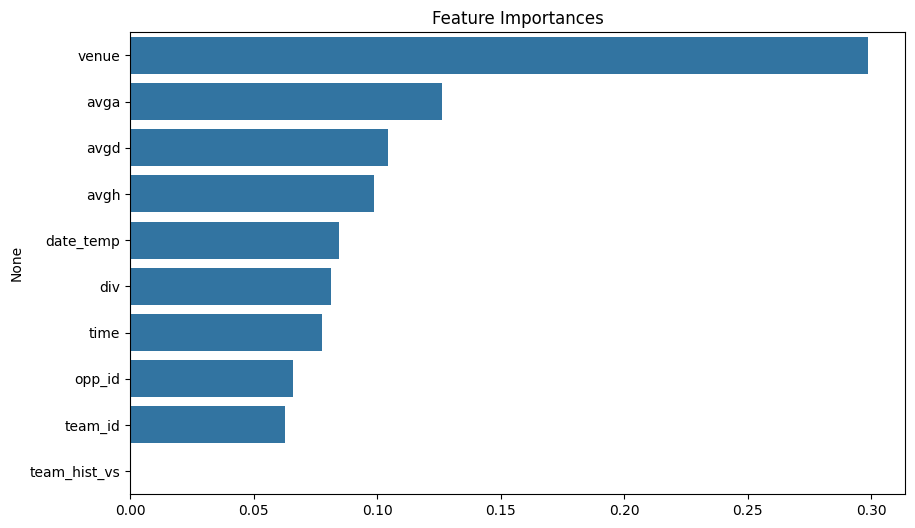

In [1850]:
# Show the 20 most important features
importances = search.best_estimator_['xgb'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=X_train.columns[indices][:20])
plt.title('Feature Importances')
plt.show()


### Validation

In [1851]:
# Apply the model to the validation set
y_val = df_val['ftr']
X_val = df_val.drop('ftr', axis=1)
y_pred = search.predict(X_val)

# print the classification report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.66      0.70        62
           1       0.53      0.63      0.58        38

    accuracy                           0.65       100
   macro avg       0.64      0.65      0.64       100
weighted avg       0.66      0.65      0.65       100

